In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import sympy
from colossus import settings
from colossus import defaults
from colossus.cosmology import cosmology
from colossus.halo import mass_so
from colossus.halo import mass_adv
from colossus.halo import mass_defs
from colossus.halo import concentration
from colossus.halo.profile_nfw import NFWProfile
from colossus.lss import mass_function

In [3]:
# Set up cosmology
params = {'flat': True, 'H0': 70, 'Om0': 0.3, 'Ob0': 0.045, 'sigma8': 0.80, 'ns': 0.96}
cosmo = cosmology.setCosmology('myCosmo', params)
print ("cosmology set")

cosmology set


In [4]:
#According to (Tinker et al. 2008, "https://iopscience.iop.org/article/10.1086/591439")
def f_sigma_200m(sigma,z):
    A_0=0.186
    a_0=1.47
    b_0=2.57
    c_0=1.19
    A_z=A_0*(1.0+min(z,2.5))**(-0.14)
    a_z=a_0*(1.0+min(z,2.5))**(-0.06)
    alpha=10.0**(-(0.75/np.log10(200/75))**(1.2))
    b_z=b_0*(1.0+min(z,2.5))**(-alpha)
    c_z=c_0
    f = A_z*((sigma/b_z)**(-a_z)+1.0)*np.exp(-c_z/sigma**2)
    return f

def f_sigma_delta(sigma,z,delta):
    if (delta >= 1600):
        A_0=0.26
    else:
        A_0=0.1*np.log10(delta)-0.05
    if (delta > 225):
        a_0=1.43+(np.log10(delta)-2.3)**(1.5)
        b_0=1.0+(np.log10(delta)-1.6)**(-1.5)
        c_0=1.2+(np.log10(delta)-2.35)**(1.6)
    else:
        a_0=1.47
        b_0=2.57
        c_0=1.19
    A_z=A_0*(1.0+min(z,2.5))**(-0.14)
    a_z=a_0*(1.0+min(z,2.5))**(-0.06)
    alpha=10.0**(-(0.75/np.log10(delta/75))**(1.2))
    b_z=b_0*(1.0+min(z,2.5))**(-alpha)
    c_z=c_0
    f = A_z*((sigma/b_z)**(-a_z)+1.0)*np.exp(-c_z/sigma**2)
    return f
def f_sigma(sigma):
    f= 0.150*(1+(sigma/2.54)**-1.36)*np.exp(-1.14/sigma**2)
    return f

In [5]:
#Output is halo mass function dn/dM with mass definition of 'M200m'
def hmf_200m(M200m,z):
    R=(3*M200m/(4*np.pi*cosmo.rho_m(0.0)))**(1.0/3)/1000
    sigma=cosmo.sigma(R,z)
    dn_dM=-f_sigma_200m(sigma,z)*cosmo.sigma(R,z,derivative=True)/M200m/(R)**3/(4*np.pi)
    return dn_dM

In [6]:
#Output is halo mass function dn/dM with mass definition of 'M200c'
def hmf_200c(M200c,z):
    R=(3*M200c/(4*np.pi*cosmo.rho_m(0.0)))**(1.0/3)/1000
    sigma=cosmo.sigma(R,z)
    delta=200.0*cosmo.rho_c(z)/cosmo.rho_m(z)
    sigma=cosmo.sigma(R,z)
    dn_dM=-f_sigma_delta(sigma,z,delta)*cosmo.sigma(R,z,derivative=True)/M200c/(R)**3/(4*np.pi)
    return dn_dM

In [7]:
#Output is log of halo mass function log(dn/dlogM) with mass definition of 'M200c'
def lghmf_200c(M200c,z):
    R=(3*(M200c)/(4*np.pi*cosmo.rho_m(0.0)))**(1.0/3)/1000
    sigma=cosmo.sigma(R,z)
    delta=200.0*cosmo.rho_c(z)/cosmo.rho_m(z)
    sigma=cosmo.sigma(R,z)
    dn_dlgM=(-f_sigma_delta(sigma,z,delta)*cosmo.sigma(R,z,derivative=True)/M200c/(R)**3/(4*np.pi))*M200c
    return np.log10(dn_dlgM)

In [8]:
#Fitting Halo Mass Function to f(\sigma) in SCORCH I
def hmf_200(M200,z):
    R=(3*M200/(4*np.pi*cosmo.rho_m(0.0)))**(1.0/3)/1000
    sigma=cosmo.sigma(R,z)
    delta=200.0*cosmo.rho_c(z)/cosmo.rho_m(z)
    sigma=cosmo.sigma(R,z)
    dn_dM=-f_sigma(sigma)*cosmo.sigma(R,z,derivative=True)/M200/(R)**3/(4*np.pi)
    return dn_dM
def lghmf_200(M200,z):
    R=(3*(M200)/(4*np.pi*cosmo.rho_m(0.0)))**(1.0/3)/1000
    sigma=cosmo.sigma(R,z)
    delta=200.0*cosmo.rho_c(z)/cosmo.rho_m(z)
    sigma=cosmo.sigma(R,z)
    dn_dlgM=(-1*f_sigma(sigma)*cosmo.sigma(R,z,derivative=True)/M200/(R)**3/(4*np.pi))*M200*np.log(10)
    return np.log10(dn_dlgM)

In [9]:
#Equation for mass in terms of mass accretion rate
def m_mar(Macc, z):
    M= 4.2e8*((Macc)**0.91)*((1+z)/7)**-2.4
    return M
#Derivatice of mass in terms of mass accretion rate
def dm_dmar(Macc,z):
    dM_dMacc= 4.2e8*0.91*((Macc)**-0.09)*((1+z)/7)**-2.4
    return dM_dMacc
#Derivative of Mass in terms of log of mass accretion rate
def dm_dlgmar(Macc,z):
    dM_dlgMacc = np.log(10)*4.2e8*0.91*((Macc)**0.91)*((1+z)/7)**-2.4
    return dM_dlgMacc

In [10]:
#Equation for halo accretion rate function.
def lgdn_dlgmar(Macc,z):
    dn_dMacc= hmf_200c(m_mar(Macc,z),z)*dm_dlgmar(Macc,z)
    return np.log10(dn_dMacc)

$$\frac{dn}{d\dot{M}}= \frac{dn}{dM} \frac{dM}{d\dot{M}}$$

$$\frac{dn}{d \log{\dot{M}}}=\frac{dn}{dM} \frac{dM}{d\dot{M}}\frac{d\dot{M}}{d\log{\dot{M}}} $$

$$M= 4.2 \times 10^8 M_{\odot} \left(\frac{\dot{M}}{M_{\odot} \text{yr}^{-1}}\right)^{0.91} \left(\frac{1+z}{7}\right)^{-2.4} $$

$$\frac{dM}{d \dot{M}}=  4.2 \times 10^8 M_{\odot} \times 0.91 \times \left(\frac{\dot{M}}{M_{\odot} \text{yr}^{-1}}\right)^{-0.09} \left(\frac{1+z}{7}\right)^{-2.4} $$

$$\frac{dn}{d \log{\dot{M}}}=\frac{dn}{dM} 4.2 \times 10^8 M_{\odot} \times 0.91 \times \left(\frac{\dot{M}}{M_{\odot} \text{yr}^{-1}}\right)^{-0.09} \left(\frac{1+z}{7}\right)^{-2.4} \dot{M} $$


In [11]:
# #Parse through txt file
# mass_six= pd.read_csv('dn_by_dlgm_Scorch.txt', sep='\s+', header=0, index_col=False, usecols=[0], squeeze=True, skiprows =lambda x: x>160) 
# count_six= pd.read_csv('dn_by_dlgm_Scorch.txt', sep='\s+', header=0, index_col=False, usecols=[1], squeeze=True, skiprows =lambda x: x>160)
# mass_eight= pd.read_csv('dn_by_dlgm_Scorch.txt', sep='\s+',  index_col=False, usecols=[0], squeeze=True, skiprows =lambda x: (x<6440 or x>6600)) 
# count_eight= pd.read_csv('dn_by_dlgm_Scorch.txt', sep='\s+', index_col=False, usecols=[1], squeeze=True, skiprows =lambda x: (x<6440 or x>6600))
# mass_ten= pd.read_csv('dn_by_dlgm_Scorch.txt', sep='\s+',  index_col=False, usecols=[0], squeeze=True, skiprows =lambda x: (x<12880 or x>13036)) 
# count_ten= pd.read_csv('dn_by_dlgm_Scorch.txt', sep='\s+', index_col=False, usecols=[1], squeeze=True, skiprows =lambda x: (x<12880 or x>13036))

In [12]:
def schechterL(luminosity, phiStar, alpha, LStar):
    """Schechter luminosity function."""
    LOverLStar = (luminosity/LStar)
    return (phiStar) * LOverLStar**alpha * np.exp(- LOverLStar)

def schechterM(magnitude, phiStar, alpha, MStar):
    """Schechter luminosity function by magnitudes."""
    MStarMinM = 0.4 * (MStar - magnitude)
    return (0.4 * np.log(10) * phiStar *
            10.0**(MStarMinM * (alpha + 1.)) * np.exp(-10**MStarMinM))
def schechterCumuLM(magnitudeAB, phiStar, alpha, MStar):
    return scipy.integrate.cumtrapz(schechterM(magnitudeAB, phiStar, alpha, MStar), magnitudeAB)

def schechterCumuLMb(magnitudeAB, phiStar, alpha, MStar):
    cumulm=[]
    for mag in magnitudeAB:
        i= scipy.integrate.quad(lambda x: schechterM(x, phiStar, alpha, MStar), -23, mag)
        cumulm.append(i[0])
    return cumulm

def schechterCumuLL(luminosity, phiStar, alpha, LStar):
    return scipy.integrate.trapz(schechterL(luminosity, phiStar, alpha, LStar), luminosity/LStar)-scipy.integrate.cumtrapz(schechterL(luminosity, phiStar, alpha, LStar), luminosity/LStar)


def schechterCumuLLb(luminosity, phiStar, alpha, LStar):
    """Integrate luminosity in galaxies above luminosity=L.
    Uses an analytical formula.
    """
    # Note that the scipy.special definition of incomplete gamma is
    # normalized to one and is the lower incomplete gamma function, so
    # we have to use the complement and multiply by the unnormalized
    # integral (which is computed in schechterTotLL).
    return (schechterTotLL(phiStar, alpha, LStar) *
            (sympy.functions.special.gamma_functions.uppergamma(alpha+1., luminosity/LStar)))


def schechterCumuLLa(luminosity, phiStar, alpha, LStar):
    """Integrate luminosity in galaxies above luminosity=L.
    Uses an analytical formula.
    """
    # Note that the scipy.special definition of incomplete gamma is
    # normalized to one and is the lower incomplete gamma function, so
    # we have to use the complement and multiply by the unnormalized
    # integral (which is computed in schechterTotLL).
    return (schechterTotLL(phiStar, alpha, LStar) *
            (1. - scipy.special.gammainc(alpha+2., luminosity/LStar)))

def schechterCumuLMa(magnitudeAB, phiStar, alpha, MStar):
    """Integrate luminosity in galaxies brighter than magnitudeAB.
    Uses an analytical formula.
    """
    LStar = 4.487e20*10**(MStar/-2.5)
    lum = 4.487e20*10**(magnitudeAB/-2.5)
    return schechterCumuLLa(lum, phiStar, alpha, LStar)

def schechterTotLL(phiStar, alpha, LStar):
    """Integrate total luminosity in galaxies.
    Uses an analytical formula.
    """
    return phiStar * LStar * sympy.functions.special.gamma_functions.gamma(alpha + 1.)

def schechterTotLM(phiStar, alpha, MStar):
    """Integrate total luminosity in galaxies.
    Uses an analytical formula.
    """
    LStar = 4.487e20*10**(-0.4*MStar)
    return schechterTotLL(phiStar, alpha, LStar)


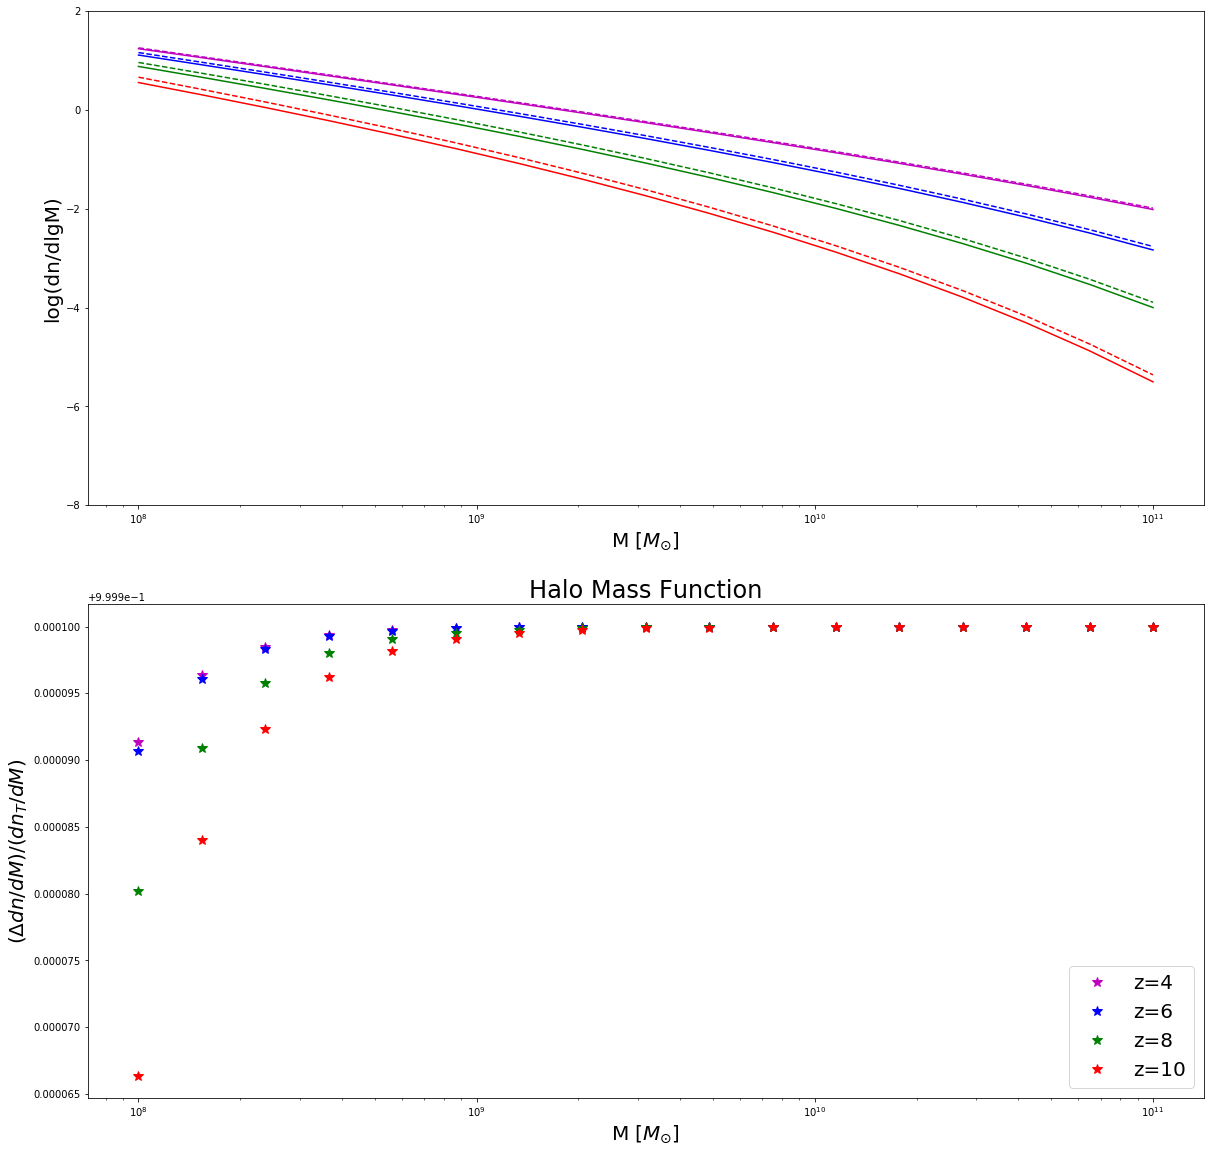

In [13]:
x = np.logspace(8, 11, num=17)
plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
plt.semilogx(x, lghmf_200c(x,4), 'm--', markersize=10, label ='z=4')
plt.semilogx(x, lghmf_200c(x,6), 'b--', markersize=10, label = 'z=6')
plt.semilogx(x, lghmf_200c(x,8), 'g--', markersize=10, label = 'z=8')
plt.semilogx(x, lghmf_200c(x,10), 'r--', markersize=10, label = 'z=10')

plt.semilogx(x, np.log10(mass_function.massFunction(x, 4, 'M', 'dndlnM', '200c','tinker08')), 'm',  label= 'z=4')
plt.semilogx(x, np.log10(mass_function.massFunction(x, 6, 'M', 'dndlnM', '200c','tinker08')), 'b',  label= 'z=6')
plt.semilogx(x, np.log10(mass_function.massFunction(x, 8, 'M', 'dndlnM', '200c','tinker08')), 'g',  label= 'z=8')
plt.semilogx(x, np.log10(mass_function.massFunction(x, 10, 'M', 'dndlnM', '200c','tinker08')), 'r', label= 'z=10')


plt.xlabel('M [$M_{\odot} $]', fontsize=20)
plt.ylabel('log(dn/dlgM)', fontsize=20)
plt.ylim(-8, 2)

plt.subplot(2,1,2)
plt.semilogx(x, (-hmf_200c(x,4)+mass_function.massFunction(x, 4, 'M', 'M2dndM', '200c','tinker08'))/mass_function.massFunction(x, 4, 'M', 'M2dndM', '200c','tinker08'), 'm*', markersize=10, label= 'z=4')
plt.semilogx(x, (-hmf_200c(x,6)+mass_function.massFunction(x, 6, 'M', 'M2dndM', '200c','tinker08'))/mass_function.massFunction(x, 6, 'M', 'M2dndM', '200c','tinker08'), 'b*', markersize=10, label= 'z=6')
plt.semilogx(x, (-hmf_200c(x,4)+mass_function.massFunction(x, 8, 'M', 'M2dndM', '200c','tinker08'))/mass_function.massFunction(x, 8, 'M', 'M2dndM', '200c','tinker08'), 'g*', markersize=10, label= 'z=8')
plt.semilogx(x, (-hmf_200c(x,6)+mass_function.massFunction(x, 10, 'M', 'M2dndM', '200c','tinker08'))/mass_function.massFunction(x, 10, 'M', 'M2dndM', '200c','tinker08'), 'r*', markersize=10, label= 'z=10')
plt.ylabel('$(\Delta dn/dM) / (dn_{T}/dM) $', fontsize=20)
plt.xlabel('M [$M_{\odot} $]', fontsize=20)

plt.title("Halo Mass Function", fontsize=24)
plt.legend(fontsize=20)
plt.show()

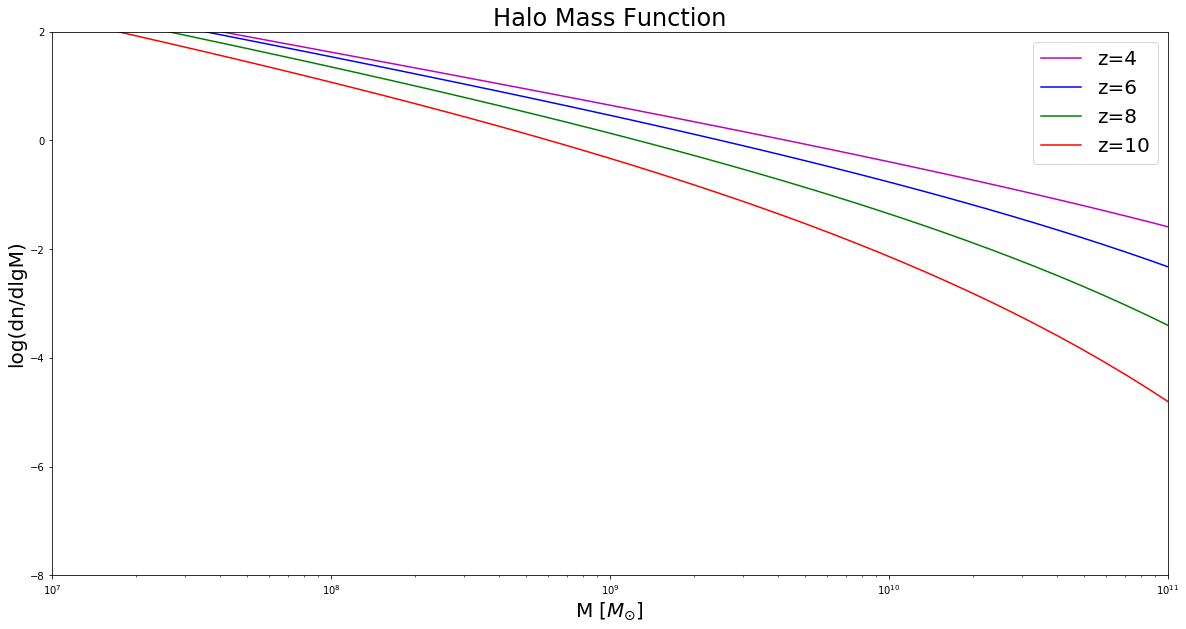

In [14]:
x = np.logspace(6, 14, num=100)
plt.figure(figsize=(20,10))

plt.xlim([1e7, 1e11])
plt.ylim([-8,2])
# plt.semilogx(mass_six, np.log10(count_six), 'b--', label= 'Scorch fit z=6')
# plt.semilogx(mass_eight, np.log10(count_eight), 'g--', label= 'Scorch fit z=8')
# plt.semilogx(mass_ten, np.log10(count_ten), 'r--', label= 'Scorch fit z=10')
plt.semilogx(x, lghmf_200(x,4), 'm',  label ='z=4')
plt.semilogx(x, lghmf_200(x,6), 'b',  label = 'z=6')
plt.semilogx(x, lghmf_200(x,8), 'g',  label = 'z=8')
plt.semilogx(x, lghmf_200(x,10), 'r',  label = 'z=10')
plt.ylabel('log(dn/dlgM)', fontsize=20)
plt.xlabel('M [$M_{\odot} $]', fontsize=20)

plt.title("Halo Mass Function", fontsize=24)
plt.legend(fontsize=20)
plt.show()

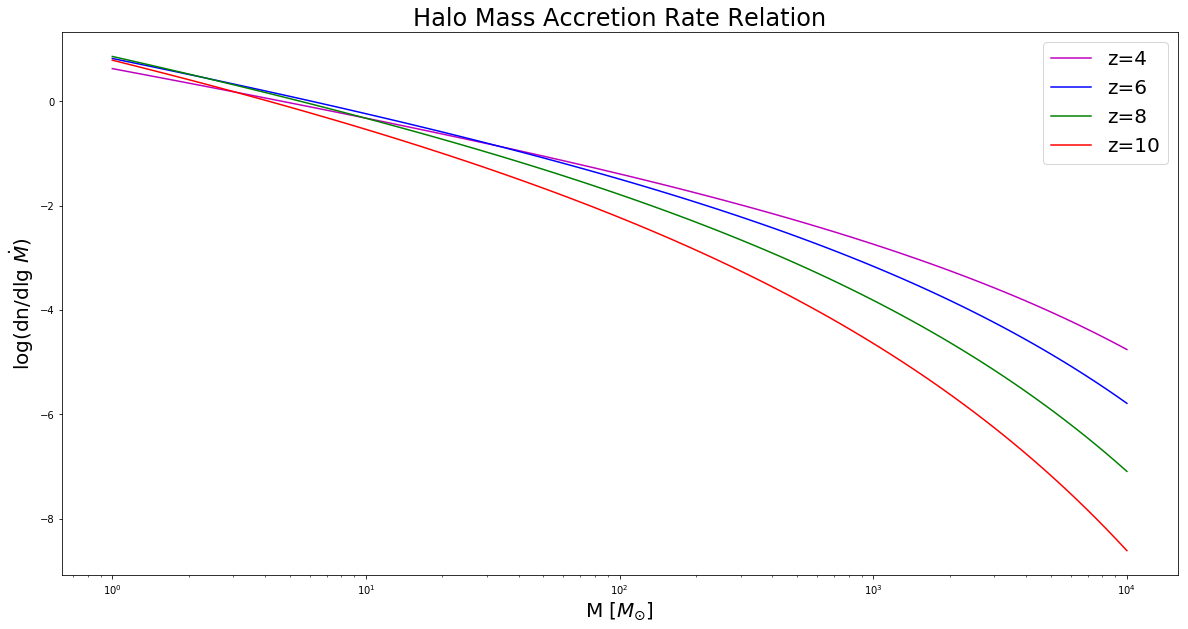

In [15]:
y = np.logspace(0, 4, num=100)
plt.figure(figsize=(20,10))

plt.semilogx(y, lgdn_dlgmar(y,4), 'm', markersize=10, label ='z=4')
plt.semilogx(y, lgdn_dlgmar(y,6), 'b', markersize=10, label ='z=6')
plt.semilogx(y, lgdn_dlgmar(y,8), 'g', markersize=10, label ='z=8')
plt.semilogx(y, lgdn_dlgmar(y,10), 'r', markersize=10, label ='z=10')
plt.ylabel('log(dn/dlg $\dot{M}$)', fontsize=20)
plt.xlabel('M [$M_{\odot} $]', fontsize=20)

plt.title("Halo Mass Accretion Rate Relation", fontsize=24)
plt.legend(fontsize=20)
plt.show()

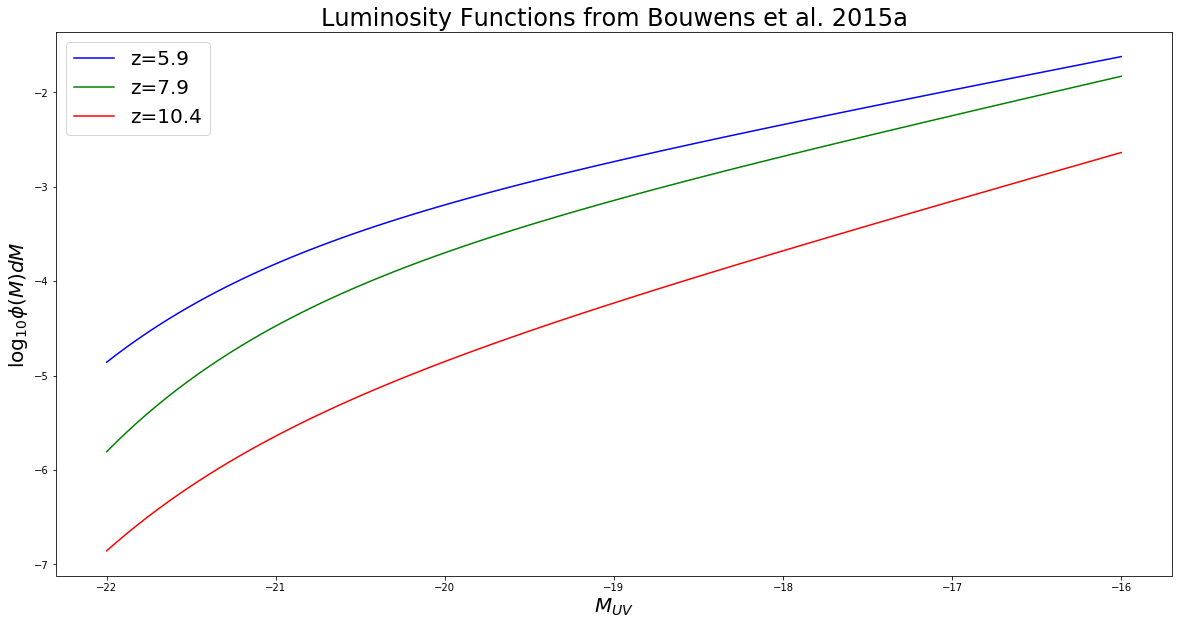

In [16]:
mag = np.linspace(-16, -22, num=100)
plt.figure(figsize=(20,10))
plt.plot(mag, np.log10(schechterM(mag, 5.0e-4,-1.87, -20.94)), 'b', markersize=10, label ='z=5.9')
plt.plot(mag, np.log10(schechterM(mag, 2.1e-4,-2.02, -20.63)), 'g', markersize=10, label ='z=7.9')
plt.plot(mag, np.log10(schechterM(mag, 8e-6,-2.27, -20.92)), 'r', markersize=10, label ='z=10.4')

plt.xlabel("$M_{UV} $", fontsize=20)
plt.ylabel("$\log_{10} \phi (M) dM$ ", fontsize=20)
plt.title("Luminosity Functions from Bouwens et al. 2015a", fontsize=24)
plt.legend(fontsize=20)
plt.show()

In [17]:
def LStar(MStar):
    return 4.487e20*10**(-0.4*MStar)
def MStar(LStar):
    return -2.5*np.log10(LStar/4.487e20)

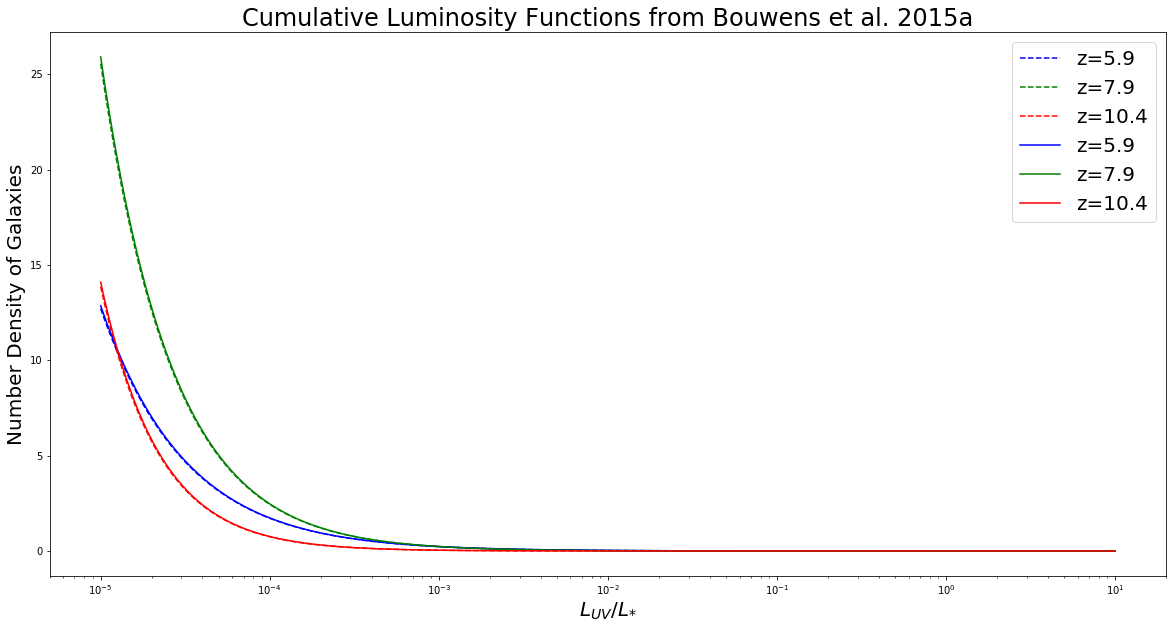

In [27]:
mag = np.linspace(-23, -16, num=1000)
lum= np.logspace(-5, 1, num=1000)
mag_star= np.linspace(-23,-16, num=999)
lum_star=  np.logspace(-5, 1, num=999)
plt.figure(figsize=(20,10))
plt.semilogx(lum_star, schechterCumuLL(lum*LStar(-20.94),5e-4,-1.87,LStar(-20.94)), 'b--', markersize=10, label ='z=5.9')
plt.semilogx(lum_star, schechterCumuLL(lum*LStar(-20.63),2.1e-4,-2.02,LStar(-20.63)), 'g--', markersize=10, label ='z=7.9')
plt.semilogx(lum_star, schechterCumuLL(lum*LStar(-20.92),8e-6,-2.27,LStar(-20.92)), 'r--', markersize=10, label ='z=10.4')
plt.semilogx(lum, (0.0005*(-8.31062+(1.14943*scipy.special.hyp1f1(-0.87,0.13, -lum))/lum**(0.87))), 'b', markersize=10, label ='z=5.9')
#plt.plot(mag, (schechterCumuLMa(mag, 5.0e-4,-1.87, -20.94)), 'b', markersize=10, label ='z=5.9')
plt.semilogx(lum, (0.00021*(49.6053+(0.980392*scipy.special.hyp1f1(-1.02,-0.02, -lum))/lum**(1.02))), 'g', markersize=10, label ='z=7.9')
#plt.plot(lum_star, (schechterCumuLL(lum, 3e-4,-2.27, 1)), 'r', markersize=10, label ='z=10.4')
plt.semilogx(lum, (0.000008*(3.65403+(0.787402*scipy.special.hyp1f1(-1.27,-0.27, -lum))/lum**(1.27))), 'r', markersize=10, label ='z=10.4')

#print (schechterCumuLM(mag, 5e-4, -1.87, -20.94))
#print (schechterCumuLMb(mag, 5e-4,-1.87,-20.94))

plt.xlabel("$L_{UV}/L_{*} $", fontsize=20)
plt.ylabel("Number Density of Galaxies", fontsize=20)
plt.title("Cumulative Luminosity Functions from Bouwens et al. 2015a", fontsize=24)
plt.legend(fontsize=20)
plt.show()

In [28]:
def cumuhmf(m,z): 
    cumuhm=[]
    for mag in m:
        i= scipy.integrate.quad(lambda x: hmf_200(x,z), mag, 1e13)
        cumuhm.append(i[0])
    return cumuhm

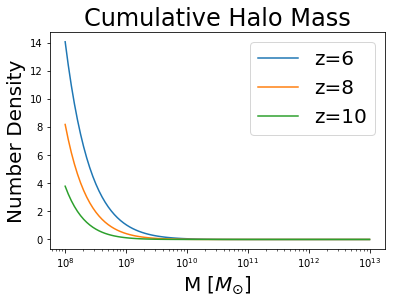

In [29]:
m= np.logspace(8,13, num=100)
plt.semilogx(m, cumuhmf(m,6), label='z=6')
plt.semilogx(m, cumuhmf(m,8), label= 'z=8')
plt.semilogx(m, cumuhmf(m,10), label= 'z=10')


plt.xlabel("M [$M_{\odot} $]", fontsize=20)
plt.ylabel("Number Density", fontsize=20)
plt.title("Cumulative Halo Mass", fontsize=24)
plt.legend(fontsize=20)
plt.show()

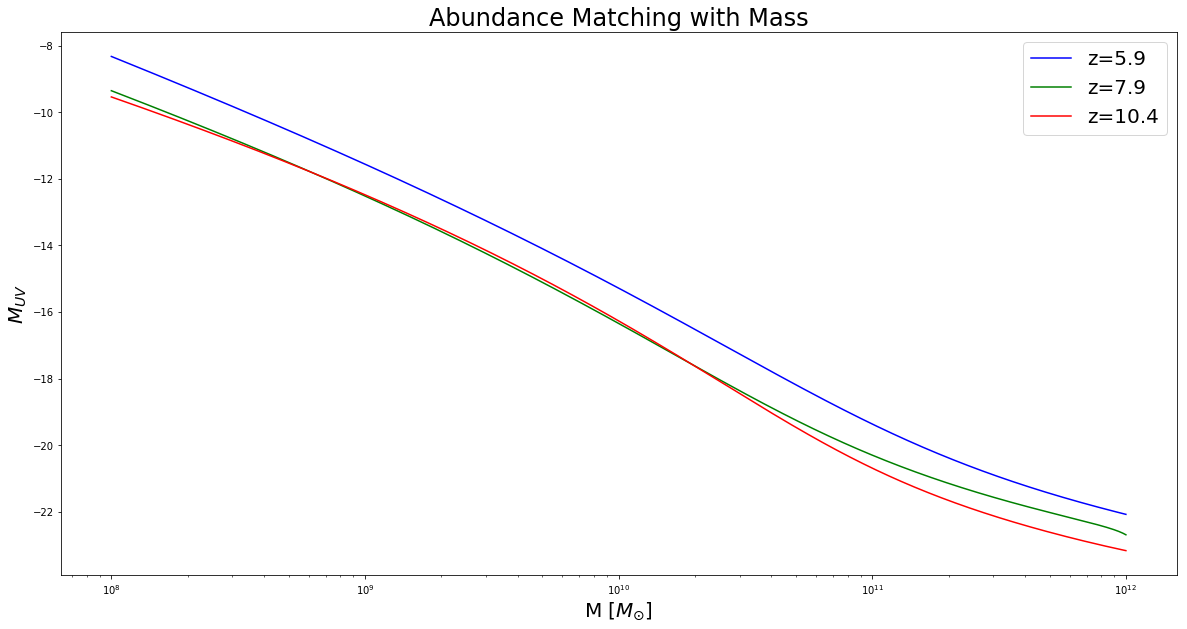

In [30]:
mag= np.linspace(-10,-25, num=1000)
lum=np.logspace(-200,200, num=100000)
mag_star= np.linspace(-10,-25, num = 999)
m= np.logspace(8,12, num=1000)
m_star=np.logspace(8,13, num=999)
f= np.interp(cumuhmf(m,6), (0.0005*(-8.31062+(1.14943*scipy.special.hyp1f1(-0.87,0.13, -lum))/lum**(0.87))),lum)
g= np.interp(cumuhmf(m,8), (0.00021*(49.6053+(0.980392*scipy.special.hyp1f1(-1.02,-0.02, -lum))/lum**(1.02))),lum)
q= scipy.interpolate.interp1d((0.0005*(-8.31062+(1.14943*scipy.special.hyp1f1(-0.87,0.13, -lum))/lum**(0.87))),lum)
p= scipy.interpolate.interp1d((0.00021*(49.6053+(0.980392*scipy.special.hyp1f1(-1.02,-0.02, -lum))/lum**(1.02))),lum)
r= scipy.interpolate.interp1d((0.000008*(3.65403+(0.787402*scipy.special.hyp1f1(-1.27,-0.27, -lum))/lum**(1.27))), lum)
#h= np.interp(cumuhmf(m,10), schechterCumuLLb(lum, 3e-4,-2.27,-20.92),mag)
#f= np.interp(cumuhmf(m,6), schechterCumuLL(lum*LStar(-20.94),5e-4,-1.87,LStar(-20.94)), lum_star)
#g= np.interp(cumuhmf(m,8), schechterCumuLL(lum*LStar(-20.63),2.1e-4,-2.02,LStar(-20.94)), lum_star)
plt.figure(figsize=(20,10))
plt.semilogx(m, MStar(q(cumuhmf(m,6))*LStar(-20.94)), 'b', markersize=10, label ='z=5.9')
plt.semilogx(m, MStar(p(cumuhmf(m,8))*LStar(-20.63)), 'g', markersize=10, label ='z=7.9')
plt.semilogx(m, MStar(r(cumuhmf(m,10))*LStar(-20.92)), 'r', markersize=10, label ='z=10.4')
#plt.semilogx(m, h, 'r', markersize=10, label ='z=10.4')

plt.xlabel("M [$M_{\odot} $]", fontsize=20)
plt.ylabel("$M_{UV}$", fontsize=20)
plt.title("Abundance Matching with Mass", fontsize=24)
plt.legend(fontsize=20)
plt.show()

In [31]:
def dn_dmar(macc,z):
    f=dm_dmar(macc,z)*hmf_200(m_mar(macc,z),z)
    return f
def cumumar(macc,z): 
    cumuma=[]
    for mag in macc:
        i= scipy.integrate.quad(lambda x: dn_dmar(x,z), mag, 1e5)
        cumuma.append(i[0])
    return cumuma
    

In [32]:
def AbundanceFit(m_star):
    return (-11.3-2.88*np.log10(m_star)-0.63*np.log10(1+m_star/3.5)+2.38*np.log10(1+m_star/1000))

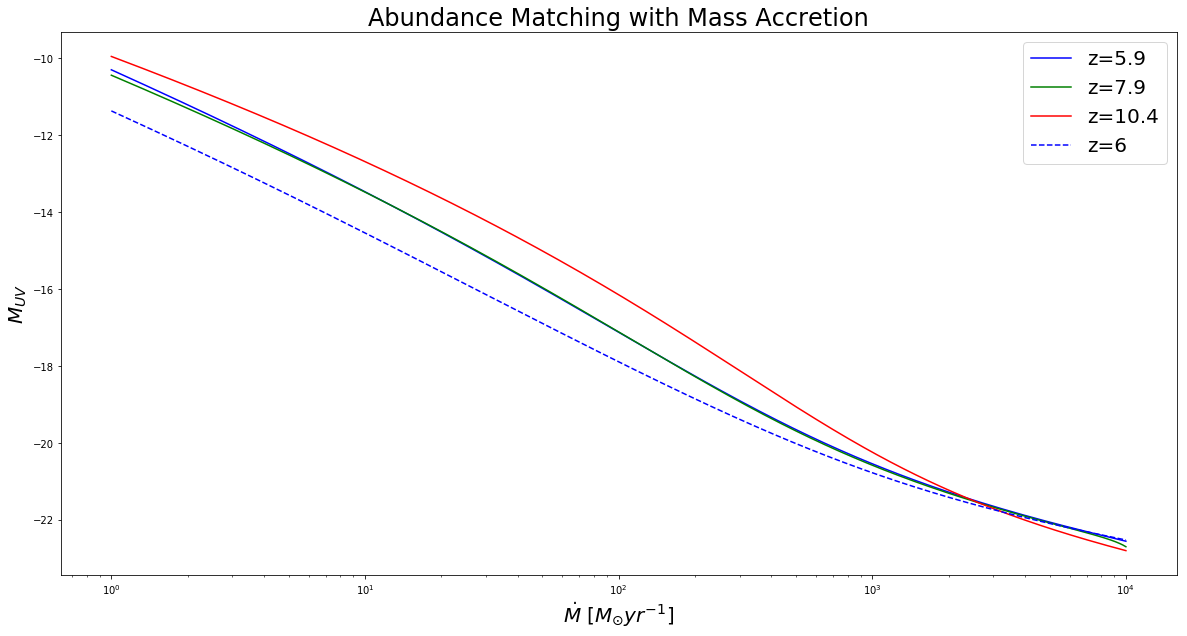

In [33]:
mdot= np.logspace(0,4, num=1000)
mdot_star=np.logspace(0,5, num=999)

plt.figure(figsize=(20,10))
plt.semilogx(mdot, MStar(q(cumumar(mdot,6))*LStar(-20.94)), 'b', markersize=10, label ='z=5.9')
plt.semilogx(mdot, MStar(p(cumumar(mdot,8))*LStar(-20.63)), 'g', markersize=10, label ='z=7.9')
plt.semilogx(mdot, MStar(r(cumumar(mdot,10))*LStar(-20.92)), 'r', markersize=10, label ='z=10.4')
plt.semilogx(mdot, AbundanceFit(mdot),'b--', markersize=10, label = 'z=6')


plt.xlabel("$\dot{M}$ [$M_{\odot}yr^{-1}$]", fontsize=20)
plt.ylabel("$M_{UV}$", fontsize=20)
plt.title("Abundance Matching with Mass Accretion", fontsize=24)
plt.legend(fontsize=20)
plt.show()

In [34]:
def magtomar(mag,z):
    mdot= np.logspace(0,4, num=1000)
    if (z==6):
        magfunc= scipy.interpolate.interp1d(MStar(q(cumumar(mdot,z))*LStar(-20.94)), mdot)
    else: 
        if (z==8):
            magfunc = scipy.interpolate.interp1d(MStar(p(cumumar(mdot,z))*LStar(-20.63)), mdot)
        else: 
            magfunc = scipy.interpolate.interp1d(MStar(r(cumumar(mdot,z))*LStar(-20.92)), mdot)
    return np.gradient(magfunc(mag))*dn_dmar(magfunc(mag),z)

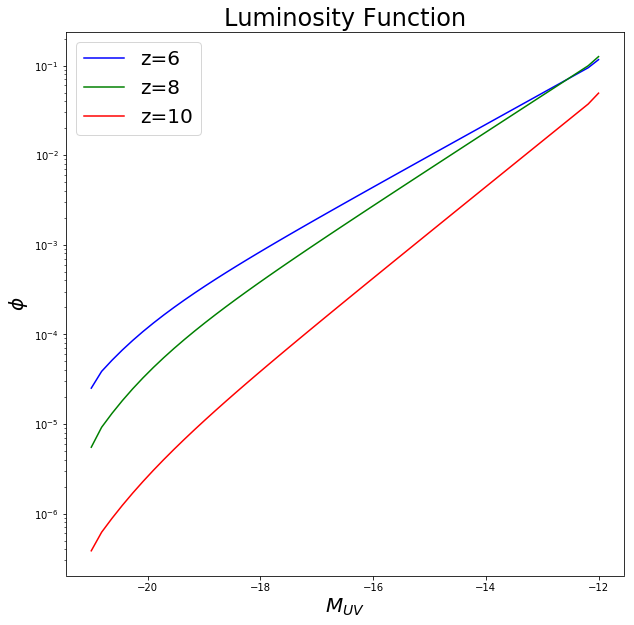

In [36]:
mag=np.linspace (-21, -12)
plt.figure(figsize=(10,10))
plt.semilogy(mag, -magtomar(mag,6), 'b', label= 'z=6')
plt.semilogy(mag, -magtomar(mag,8), 'g', label= 'z=8')
plt.semilogy(mag, -magtomar(mag,10), 'r', label= 'z=10')
plt.ylabel("$\phi$", fontsize=20)
plt.xlabel("$M_{UV}$", fontsize=20)
plt.title("Luminosity Function", fontsize=24)
plt.legend(fontsize=20)
plt.show()